In [75]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import scipy
from scipy import sparse
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

In [76]:
plt.rc("font", size = 14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [149]:
def runXGB(num_rounds, train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
    param = {}
    param['num_rounds'] = num_rounds
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.3
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    #num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
        
    return pred_test_y, model, plst


In [154]:
train_file ="train.json"
train_df = pd.read_json(train_file)
features_to_use  = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

#train_X = scipy.sparse.csr_matrix(train_df[features_to_use].values)
train_X = train_df[features_to_use].values

cv_scores = []

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2016)

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

model_num = 0
num_rounds = 1500

#### Check if the classes are balanced

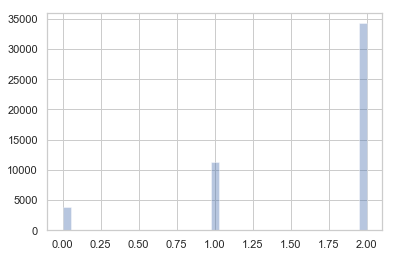

In [143]:
sns.distplot(train_y, kde = False)

#### Classes are highly inbalanced 
Thus, let's oversmapling minority classes by SMOTE algorithm

In [144]:
# oversampling
smote = SMOTE('not majority')
x_sm, y_sm = smote.fit_sample(train_X, train_y)

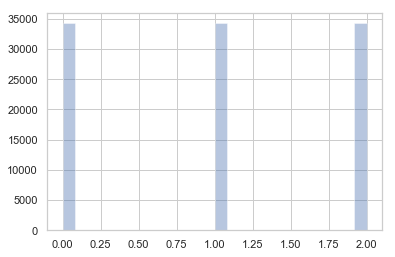

In [145]:
sns.distplot(y_sm, kde = False)

In [153]:
# Run
for dev_index, val_index in kf.split(range(x_sm.shape[0])):
    
        model_num += 1
        
        dev_X, val_X = x_sm[dev_index,:], x_sm[val_index,:]
        dev_y, val_y = y_sm[dev_index], y_sm[val_index]
        preds, model, parameters = runXGB(num_rounds, dev_X, dev_y, val_X, val_y)
        cv_scores.append(log_loss(val_y, preds))
        
        print('model # =', model_num)
        print(cv_scores)
        break

[0]	train-mlogloss:1.04499	test-mlogloss:1.0458
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[1]	train-mlogloss:1.0083	test-mlogloss:1.00956
[2]	train-mlogloss:0.995763	test-mlogloss:0.99753
[3]	train-mlogloss:0.978914	test-mlogloss:0.981412
[4]	train-mlogloss:0.954113	test-mlogloss:0.956566
[5]	train-mlogloss:0.925383	test-mlogloss:0.928165
[6]	train-mlogloss:0.912255	test-mlogloss:0.915724
[7]	train-mlogloss:0.90509	test-mlogloss:0.909116
[8]	train-mlogloss:0.897578	test-mlogloss:0.902338
[9]	train-mlogloss:0.886659	test-mlogloss:0.892212
[10]	train-mlogloss:0.87475	test-mlogloss:0.881285
[11]	train-mlogloss:0.864867	test-mlogloss:0.871943
[12]	train-mlogloss:0.857175	test-mlogloss:0.86509
[13]	train-mlogloss:0.852043	test-mlogloss:0.860466
[14]	train-mlogloss:0.848134	test-mlogloss:0.857273
[15]	train-mlogloss:0.842701	test-mlogloss:0.851885
[16]	train-mlogloss:0.839618	test-mlo

[155]	train-mlogloss:0.653562	test-mlogloss:0.716712
[156]	train-mlogloss:0.652715	test-mlogloss:0.716085
[157]	train-mlogloss:0.65193	test-mlogloss:0.715589
[158]	train-mlogloss:0.651235	test-mlogloss:0.715165
[159]	train-mlogloss:0.650819	test-mlogloss:0.714839
[160]	train-mlogloss:0.650392	test-mlogloss:0.7147
[161]	train-mlogloss:0.649637	test-mlogloss:0.714204
[162]	train-mlogloss:0.648673	test-mlogloss:0.713678
[163]	train-mlogloss:0.648183	test-mlogloss:0.713369
[164]	train-mlogloss:0.647818	test-mlogloss:0.71326
[165]	train-mlogloss:0.64737	test-mlogloss:0.713103
[166]	train-mlogloss:0.646824	test-mlogloss:0.712773
[167]	train-mlogloss:0.646362	test-mlogloss:0.712633
[168]	train-mlogloss:0.646001	test-mlogloss:0.712581
[169]	train-mlogloss:0.645604	test-mlogloss:0.712407
[170]	train-mlogloss:0.645139	test-mlogloss:0.712282
[171]	train-mlogloss:0.644661	test-mlogloss:0.712012
[172]	train-mlogloss:0.643957	test-mlogloss:0.711661
[173]	train-mlogloss:0.643633	test-mlogloss:0.71141

[311]	train-mlogloss:0.578956	test-mlogloss:0.679624
[312]	train-mlogloss:0.578493	test-mlogloss:0.679381
[313]	train-mlogloss:0.578067	test-mlogloss:0.679235
[314]	train-mlogloss:0.577464	test-mlogloss:0.678929
[315]	train-mlogloss:0.577224	test-mlogloss:0.678818
[316]	train-mlogloss:0.576879	test-mlogloss:0.678517
[317]	train-mlogloss:0.576379	test-mlogloss:0.678265
[318]	train-mlogloss:0.576032	test-mlogloss:0.678011
[319]	train-mlogloss:0.575634	test-mlogloss:0.677709
[320]	train-mlogloss:0.575189	test-mlogloss:0.677484
[321]	train-mlogloss:0.574614	test-mlogloss:0.677222
[322]	train-mlogloss:0.574196	test-mlogloss:0.676931
[323]	train-mlogloss:0.573868	test-mlogloss:0.676777
[324]	train-mlogloss:0.573634	test-mlogloss:0.676747
[325]	train-mlogloss:0.573288	test-mlogloss:0.676656
[326]	train-mlogloss:0.572989	test-mlogloss:0.676688
[327]	train-mlogloss:0.572646	test-mlogloss:0.67678
[328]	train-mlogloss:0.572345	test-mlogloss:0.676696
[329]	train-mlogloss:0.572038	test-mlogloss:0.6

[467]	train-mlogloss:0.52745	test-mlogloss:0.657874
[468]	train-mlogloss:0.527186	test-mlogloss:0.657661
[469]	train-mlogloss:0.526849	test-mlogloss:0.6575
[470]	train-mlogloss:0.526601	test-mlogloss:0.657464
[471]	train-mlogloss:0.526403	test-mlogloss:0.657362
[472]	train-mlogloss:0.526103	test-mlogloss:0.657211
[473]	train-mlogloss:0.525794	test-mlogloss:0.657116
[474]	train-mlogloss:0.525548	test-mlogloss:0.657055
[475]	train-mlogloss:0.525249	test-mlogloss:0.656984
[476]	train-mlogloss:0.524949	test-mlogloss:0.656914
[477]	train-mlogloss:0.524652	test-mlogloss:0.656757
[478]	train-mlogloss:0.524369	test-mlogloss:0.656551
[479]	train-mlogloss:0.524164	test-mlogloss:0.65649
[480]	train-mlogloss:0.523969	test-mlogloss:0.656476
[481]	train-mlogloss:0.5237	test-mlogloss:0.656399
[482]	train-mlogloss:0.523399	test-mlogloss:0.656164
[483]	train-mlogloss:0.523169	test-mlogloss:0.656052
[484]	train-mlogloss:0.522969	test-mlogloss:0.655992
[485]	train-mlogloss:0.522676	test-mlogloss:0.65587


[623]	train-mlogloss:0.486639	test-mlogloss:0.642263
[624]	train-mlogloss:0.486432	test-mlogloss:0.642175
[625]	train-mlogloss:0.486242	test-mlogloss:0.641966
[626]	train-mlogloss:0.485894	test-mlogloss:0.64168
[627]	train-mlogloss:0.485628	test-mlogloss:0.641456
[628]	train-mlogloss:0.485568	test-mlogloss:0.64146
[629]	train-mlogloss:0.485335	test-mlogloss:0.641331
[630]	train-mlogloss:0.485243	test-mlogloss:0.641321
[631]	train-mlogloss:0.484966	test-mlogloss:0.64138
[632]	train-mlogloss:0.484819	test-mlogloss:0.641304
[633]	train-mlogloss:0.484548	test-mlogloss:0.641237
[634]	train-mlogloss:0.484156	test-mlogloss:0.640986
[635]	train-mlogloss:0.483904	test-mlogloss:0.640946
[636]	train-mlogloss:0.483656	test-mlogloss:0.640864
[637]	train-mlogloss:0.483516	test-mlogloss:0.640828
[638]	train-mlogloss:0.483383	test-mlogloss:0.640788
[639]	train-mlogloss:0.483172	test-mlogloss:0.6407
[640]	train-mlogloss:0.482985	test-mlogloss:0.640647
[641]	train-mlogloss:0.482893	test-mlogloss:0.64064

[779]	train-mlogloss:0.453137	test-mlogloss:0.630404
[780]	train-mlogloss:0.452855	test-mlogloss:0.630282
[781]	train-mlogloss:0.452592	test-mlogloss:0.630321
[782]	train-mlogloss:0.452366	test-mlogloss:0.630121
[783]	train-mlogloss:0.452186	test-mlogloss:0.630039
[784]	train-mlogloss:0.451896	test-mlogloss:0.629939
[785]	train-mlogloss:0.451785	test-mlogloss:0.62991
[786]	train-mlogloss:0.451495	test-mlogloss:0.629709
[787]	train-mlogloss:0.451297	test-mlogloss:0.629665
[788]	train-mlogloss:0.451075	test-mlogloss:0.629615
[789]	train-mlogloss:0.450877	test-mlogloss:0.629556
[790]	train-mlogloss:0.45064	test-mlogloss:0.629498
[791]	train-mlogloss:0.450424	test-mlogloss:0.62946
[792]	train-mlogloss:0.450302	test-mlogloss:0.629434
[793]	train-mlogloss:0.450138	test-mlogloss:0.629375
[794]	train-mlogloss:0.449968	test-mlogloss:0.629275
[795]	train-mlogloss:0.449726	test-mlogloss:0.629116
[796]	train-mlogloss:0.449541	test-mlogloss:0.629063
[797]	train-mlogloss:0.449226	test-mlogloss:0.628

[935]	train-mlogloss:0.424501	test-mlogloss:0.622941
[936]	train-mlogloss:0.424227	test-mlogloss:0.622773
[937]	train-mlogloss:0.424029	test-mlogloss:0.622709
[938]	train-mlogloss:0.423896	test-mlogloss:0.622733
[939]	train-mlogloss:0.42362	test-mlogloss:0.622805
[940]	train-mlogloss:0.423457	test-mlogloss:0.622667
[941]	train-mlogloss:0.423225	test-mlogloss:0.622644
[942]	train-mlogloss:0.423076	test-mlogloss:0.622566
[943]	train-mlogloss:0.422706	test-mlogloss:0.622525
[944]	train-mlogloss:0.422502	test-mlogloss:0.622356
[945]	train-mlogloss:0.422333	test-mlogloss:0.622295
[946]	train-mlogloss:0.422105	test-mlogloss:0.622267
[947]	train-mlogloss:0.421838	test-mlogloss:0.62222
[948]	train-mlogloss:0.421554	test-mlogloss:0.622096
[949]	train-mlogloss:0.421392	test-mlogloss:0.621992
[950]	train-mlogloss:0.421235	test-mlogloss:0.622014
[951]	train-mlogloss:0.421094	test-mlogloss:0.622005
[952]	train-mlogloss:0.420851	test-mlogloss:0.621893
[953]	train-mlogloss:0.420694	test-mlogloss:0.62

[1089]	train-mlogloss:0.398889	test-mlogloss:0.616069
[1090]	train-mlogloss:0.398695	test-mlogloss:0.616001
[1091]	train-mlogloss:0.398618	test-mlogloss:0.616057
[1092]	train-mlogloss:0.398381	test-mlogloss:0.61614
[1093]	train-mlogloss:0.398298	test-mlogloss:0.616072
[1094]	train-mlogloss:0.398137	test-mlogloss:0.616055
[1095]	train-mlogloss:0.398034	test-mlogloss:0.615995
[1096]	train-mlogloss:0.397931	test-mlogloss:0.6159
[1097]	train-mlogloss:0.397803	test-mlogloss:0.615864
[1098]	train-mlogloss:0.397699	test-mlogloss:0.61586
[1099]	train-mlogloss:0.397517	test-mlogloss:0.615749
[1100]	train-mlogloss:0.397411	test-mlogloss:0.615758
[1101]	train-mlogloss:0.397346	test-mlogloss:0.615826
[1102]	train-mlogloss:0.397214	test-mlogloss:0.615859
[1103]	train-mlogloss:0.396998	test-mlogloss:0.615717
[1104]	train-mlogloss:0.39688	test-mlogloss:0.615723
[1105]	train-mlogloss:0.396688	test-mlogloss:0.615803
[1106]	train-mlogloss:0.396519	test-mlogloss:0.615701
[1107]	train-mlogloss:0.396421	te

[1242]	train-mlogloss:0.377465	test-mlogloss:0.61151
[1243]	train-mlogloss:0.377351	test-mlogloss:0.611556
[1244]	train-mlogloss:0.377236	test-mlogloss:0.611636
[1245]	train-mlogloss:0.377032	test-mlogloss:0.611459
[1246]	train-mlogloss:0.376938	test-mlogloss:0.611518
[1247]	train-mlogloss:0.376876	test-mlogloss:0.611552
[1248]	train-mlogloss:0.376758	test-mlogloss:0.611527
[1249]	train-mlogloss:0.376602	test-mlogloss:0.611423
[1250]	train-mlogloss:0.376459	test-mlogloss:0.611492
[1251]	train-mlogloss:0.37632	test-mlogloss:0.61154
[1252]	train-mlogloss:0.376113	test-mlogloss:0.611431
[1253]	train-mlogloss:0.375919	test-mlogloss:0.611368
[1254]	train-mlogloss:0.375781	test-mlogloss:0.611301
[1255]	train-mlogloss:0.375687	test-mlogloss:0.611317
[1256]	train-mlogloss:0.375614	test-mlogloss:0.611386
[1257]	train-mlogloss:0.375461	test-mlogloss:0.611356
[1258]	train-mlogloss:0.375241	test-mlogloss:0.611381
[1259]	train-mlogloss:0.375183	test-mlogloss:0.611374
[1260]	train-mlogloss:0.374967	

### EDA

In [91]:
train_X

<49352x5 sparse matrix of type '<class 'numpy.float64'>'
	with 236948 stored elements in Compressed Sparse Row format>

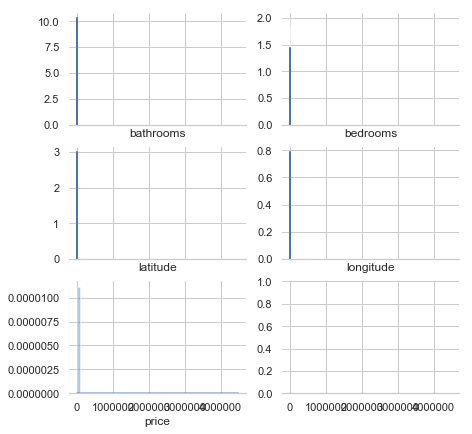

In [123]:
# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

sns.distplot(train_df['bathrooms'], ax=axes[0, 0])
sns.distplot(train_df['bedrooms'], ax=axes[0, 1])
sns.distplot(train_df['latitude'], ax=axes[1, 0])
sns.distplot(train_df['longitude'], ax=axes[1, 1])
sns.distplot(train_df['price'], ax=axes[2, 0])

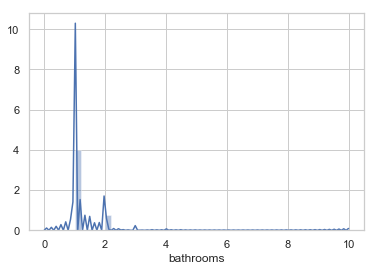

In [124]:
sns.distplot(train_df['bathrooms'])

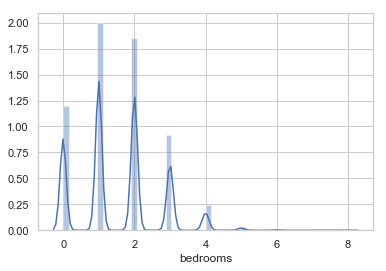

In [125]:
sns.distplot(train_df['bedrooms'])

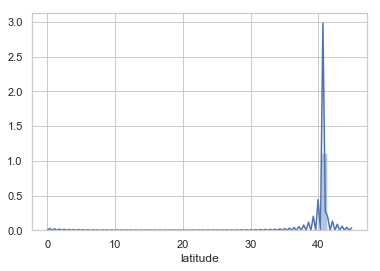

In [126]:
sns.distplot(train_df['latitude'])

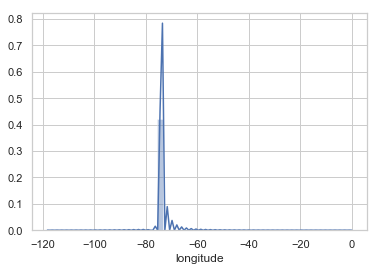

In [127]:
sns.distplot(train_df['longitude'])

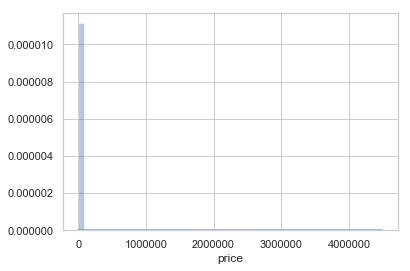

In [138]:
sns.distplot(train_df['price'])

In [135]:
train_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


(0, 100)

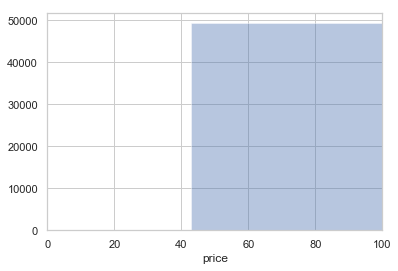

In [148]:
f = sns.distplot(train_df['price'], kde = False)
axes = f.axes
axes.set_xlim(0 , 100)

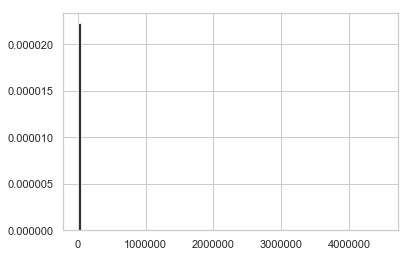

In [112]:
plt.figure(1)
train_df['price'].hist(bins = 100, color = 'black', density = True, alpha = 0.8)  

In [114]:
corrs = train_df.corr()
corrs

,bathrooms,bedrooms,latitude,listing_id,longitude,price
bathrooms,1.000000,0.533446,-0.009657,0.000776,0.010393,0.069661
bedrooms,0.533446,1.000000,-0.004745,0.011968,0.006892,0.051788
latitude,-0.009657,-0.004745,1.000000,0.001712,-0.966807,-0.000707
listing_id,0.000776,0.011968,0.001712,1.000000,-0.000907,0.008090
longitude,0.010393,0.006892,-0.966807,-0.000907,1.000000,-0.000087
price,0.069661,0.051788,-0.000707,0.008090,-0.000087,1.000000


### Tuning Model's Parameters

In [155]:
# Initial params
param = {}
param['num_rounds'] = 1500
param['objective'] = 'multi:softprob'
param['eta'] = 0.3
param['max_depth'] = 6
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 0
param

{'num_rounds': 1500,
 'objective': 'multi:softprob',
 'eta': 0.3,
 'max_depth': 6,
 'silent': 1,
 'num_class': 3,
 'eval_metric': 'mlogloss',
 'min_child_weight': 1,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'seed': 0}

#### Step 1 - Find the number of rounds for the current tree's parameters

In [156]:
data_dmatrix = xgb.DMatrix(data = x_sm, label = y_sm)

In [157]:
#num_boost_round = model.get_params()['num_rounds']

In [158]:
# cross-validation by xgboost
cvresult = xgb.cv(dtrain = data_dmatrix, params = param, nfold = 5,
                    num_boost_round = 2000, early_stopping_rounds = 20, 
                    metrics = 'mlogloss', as_pandas = True, seed = 0)
%time

In [159]:
cvresult.tail()

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
1495,0.344762,0.002512,0.617046,0.005077
1496,0.344666,0.002505,0.617019,0.005060
1497,0.344552,0.002488,0.617001,0.005070
1498,0.344472,0.002479,0.616987,0.005086
1499,0.344354,0.002483,0.616991,0.005113


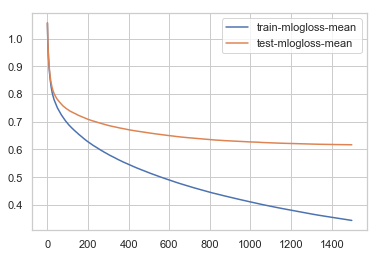

In [160]:
plt.plot(cvresult['train-mlogloss-mean'])
plt.plot(cvresult['test-mlogloss-mean'])
plt.legend()

In [170]:
# Find the best number of rounds, that is the number of iterations and update model's parameters: 
num_rounds = cvresult.shape[0]
#model.set_params(n_estimators = cvresult.shape[0])
param['num_rounds'] = 400
num_rounds

1500

#### Step 2 - Tune max_depth and min_child_weight¶

In [162]:
# Define parameters that we are going to test
test_params = {
 'max_depth':range(4, 7, 1), 
    'min_child_weight':range(1, 4, 2)
}

In [173]:
param

{'num_rounds': 400,
 'objective': 'multi:softprob',
 'eta': 0.3,
 'max_depth': 6,
 'silent': 1,
 'num_class': 3,
 'eval_metric': 'mlogloss',
 'min_child_weight': 1,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'seed': 0}

In [164]:
model = XGBClassifier(learning_rate = param['eta'], n_estimators = param['num_rounds'], 
                      subsample = param['subsample'], colsample_bytree = param['colsample_bytree'], 
                      objective = param['objective'], seed = param['seed'])

In [167]:
# plot feature importance
#plot_importance(model)
#plt.show()

In [168]:
# GridSearchCV1
grid_search1 = GridSearchCV(estimator = model, 
                            param_grid = test_params, scoring = 'neg_log_loss', n_jobs = 4, iid = False, cv = 5)

In [169]:
grid_search1.fit(x_sm, y_sm)
%time

Wall time: 0 ns


In [172]:
grid_search1.best_params_, grid_search1.best_score_

({'max_depth': 6, 'min_child_weight': 1}, -0.6385072962285011)

In [36]:
#grid_search1.grid_scores_

In [174]:
# Define parameters that we are going to test
test_params = {
 'max_depth':[5, 6, 7], 
    'min_child_weight':[1, 2]
}

In [175]:
# GridSearchCV2
grid_search2 = GridSearchCV(estimator = model, 
                            param_grid = test_params, scoring = 'neg_log_loss', n_jobs = 4, iid = False, cv = 5)

In [ ]:
grid_search2.fit(x_sm, y_sm)

In [171]:
grid_search2.best_params_, grid_search2.best_score_

({'max_depth': 6, 'min_child_weight': 1}, -0.651939128503577)

In [ ]:
# Update new parameters
param['max_depth'] = 
param['min_child_weight'] = 

#### Step 3 - Tune gamma

In [ ]:
test_params = {
 'gamma':[i/10.0 for i in range(0,5)]
}

#### Step 4 - Tune subsample and colsample_bytree

In [ ]:
test_params = {
 'subsample':[0.7, 0.8],
 'colsample_bytree':[0.7, 0.8]
}

#### Step 5 - Tuning Regularization Parameters

#### Step 6 - Reducing Learning Rate